In [1]:
import timm
import torch
import wandb
import fastai
import dill
from sklearn.utils.class_weight import compute_class_weight
from fastai.callback.wandb import WandbCallback
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.text.core import RegexLabeller
from fastai.vision.utils import get_image_files
from fastai.data.block import DataBlock
from fastai.data.core import *
from fastai.tabular.all import *
os.environ['WANDB_NOTEBOOK_NAME'] = 'Parameter_Optimization_Sweep.ipynb'

In [2]:
# define configs and parameters
# define static parameters
meta_config = SimpleNamespace(
    dataset_path = r"/blue/hulcr/gmarais/Beetle_data/selected_images/train_data",
    img_size=224,
    seed=42,
    project="Ambrosia_Symbiosis",
    # group="Beetle_classifier",
    # job_type="parameter_optimization"
    )

# define parameter optimization config
sweep_config = {
    'name': 'Beetle_Classifier_Sweep',
    'project':meta_config.project,
    'method': 'bayes',
    'run_cap':10,
    'metric': {
        'goal': 'minimize', 
        'name': 'validation_loss'
        },
    # 'early_terminate':{
    #     'type': 'hyperband',
    #     'min_iter': 1,
    #     'max_iter': 100,
    #     'eta': 3,
    #     's': 2
    # },
    'parameters': {
        'pretrained':{'values': [True, False]},
        'model_name':{'values': ['resnet50', 'maxvit_rmlp_small_rw_224.sw_in1k', 'maxvit_rmlp_base_rw_224.sw_in12k', 'maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k']},
        'batch_size': {'values': [8, 16, 32, 64]},
        'epochs': {'max': 50, 'min': 1},
        'lr':{'min':1e-6,'max': 1e-2}
     }
}

In [4]:
# define functions required for sweep
# def get_images(dataset_path, batch_size, img_size, seed, subfolders=('train','valid')):
#     "The beetles dataset"
#     files = get_image_files(path=dataset_path, recurse=True, folders=subfolders)
#     dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
#                        get_items = get_image_files,
#                        splitter = GrandparentSplitter(train_name=subfolders[0], valid_name=subfolders[1]),
#                        get_y = parent_label,
#                        item_tfms = Resize(img_size, ResizeMethod.Pad, pad_mode='zeros'))
#     dls = dblock.dataloaders(dataset_path, bs = batch_size)
#     return dls

def get_images(dataset_path, batch_size, img_size, seed, subfolders=('train','valid')):
    "The beetles dataset"
    files = get_image_files(path=dataset_path, recurse=True, folders=subfolders)
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       splitter = GrandparentSplitter(train_name=subfolders[0], valid_name=subfolders[1]),
                       get_y = parent_label,
                       item_tfms = Resize(img_size, ResizeMethod.Pad, pad_mode='zeros'), # resize trasnformation is applied during inference too                                    
                       batch_tfms = aug_transforms(    # transformatiosn that are only applied ot training and not inference
                           batch=False,
                           pad_mode='zeros',
                           size=img_size
                           p_affine=0.8
                           p_lighting=0.8
                           max_rotate=360.0,
                           mult=1.0, 
                           do_flip=True, 
                           flip_vert=False,
                           max_rotate=10.0, 
                           min_zoom=1.0,
                           max_zoom=1.1, 
                           max_lighting=0.2,
                           max_warp=0.2, 
                           mode='bilinear', 
                           align_corners=True,
                           min_scale=1.0
                                       ))
    dls = dblock.dataloaders(dataset_path, bs = batch_size)
    return dls

def train(meta_config):
    "Train the model using the supplied configs"
    run = wandb.init(project=meta_config.project) # , job_type=meta_config.job_type, group =meta_config.group, 
    dls = get_images(dataset_path=meta_config.dataset_path, img_size=meta_config.img_size, seed=meta_config.seed, batch_size=wandb.config.batch_size)
    labels = np.array([str(x).split('/')[-2] for x in dls.items])
    classes = np.unique(labels)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    class_weights = {c: w for c, w in zip(classes, weights)}
    weights = tensor([class_weights[c] for c in dls.vocab]).to(dls.device)
    cbs = [MixedPrecision(), ShowGraphCallback(), SaveModelCallback(), WandbCallback(log='all')] 
    learn = vision_learner(dls, 
                           wandb.config.model_name,
                           loss_func=LabelSmoothingCrossEntropy(weight=weights),
                           metrics=[error_rate, 
                                    accuracy, 
                                    top_k_accuracy], 
                           cbs=cbs, 
                           pretrained=wandb.config.pretrained)
    learn.fine_tune(wandb.config.epochs, base_lr=wandb.config.lr)
    run.finish()
    
# Prepare training wrapper based on configs
def train_wrapper():
    train(meta_config = meta_config)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Parameter_Optimization_Sweep.ipynb.


Create sweep with ID: vs3ybs0t
Sweep URL: https://wandb.ai/christopher-marais/Ambrosia_Symbiosis/sweeps/vs3ybs0t


wandb: Agent Starting Run: 1rhcnu76 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 49
wandb: 	lr: 0.0002775944262963546
wandb: 	model_name: resnet50
wandb: 	pretrained: False
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Parameter_Optimization_Sweep.ipynb.
wandb: Currently logged in as: christopher-marais. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.649439,1.274239,0.287398,0.712602,0.974153,02:07


Better model found at epoch 0 with valid_loss value: 1.2742388248443604.


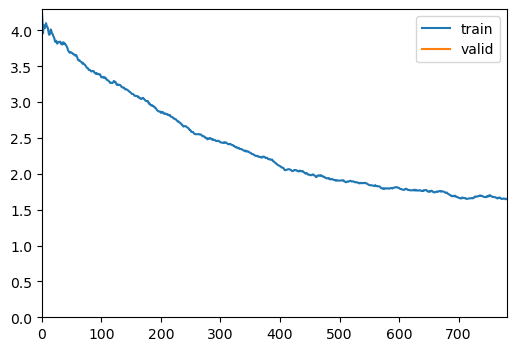

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,1.376369,1.077028,0.207446,0.792554,0.990358,01:25
1,1.317038,1.041616,0.185885,0.814115,0.993572,01:19
2,1.265473,1.007118,0.163118,0.836882,0.994375,01:21
3,1.233273,0.986938,0.157493,0.842507,0.994241,01:20
4,1.182260,0.966502,0.154279,0.845721,0.995179,01:21
5,1.138369,0.949135,0.146243,0.853757,0.995581,01:20
6,1.105139,0.947833,0.143699,0.856301,0.994107,01:20
7,1.080258,0.922022,0.127226,0.872774,0.997589,01:21
8,1.035329,0.887121,0.112227,0.887773,0.997723,01:20
9,1.014312,0.896868,0.119459,0.880541,0.995848,01:20


Better model found at epoch 0 with valid_loss value: 1.0770282745361328.


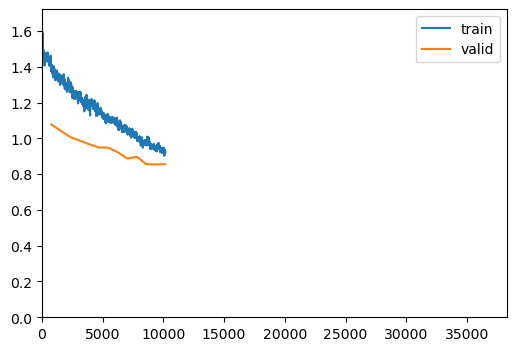

Better model found at epoch 1 with valid_loss value: 1.041615605354309.
Better model found at epoch 2 with valid_loss value: 1.0071176290512085.
Better model found at epoch 3 with valid_loss value: 0.9869384169578552.
Better model found at epoch 4 with valid_loss value: 0.9665024280548096.
Better model found at epoch 5 with valid_loss value: 0.9491353034973145.
Better model found at epoch 6 with valid_loss value: 0.9478334784507751.
Better model found at epoch 7 with valid_loss value: 0.9220218658447266.
Better model found at epoch 8 with valid_loss value: 0.8871210217475891.
Better model found at epoch 10 with valid_loss value: 0.8553967475891113.
Better model found at epoch 11 with valid_loss value: 0.854388415813446.


wandb: Ctrl + C detected. Stopping sweep.


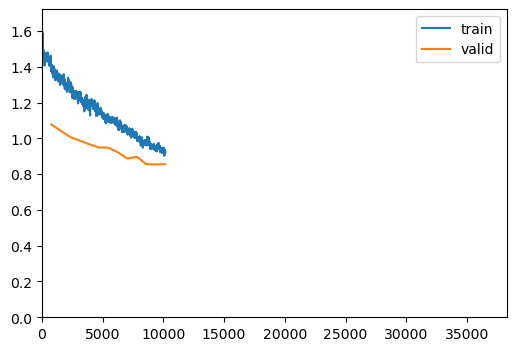

In [5]:
# Run sweep    
sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train_wrapper)